In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 0. Загрузка данных

In [2]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [3]:
data_train = pd.read_csv(TRAIN_DATASET_PATH)

In [4]:
df = data_train.copy()

### 1. Обзор данных и приведение типов

In [5]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [6]:
df.shape

(7500, 17)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

#### 1.1 Преобразуем колонку "Years in current job" в переменную, отпарсив значения. 

In [8]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

#### 1.2 Для значения '< 1 year' примем стаж равным нулю, а для остальных - их текущие значения.

In [9]:
df['Years in current job'] = df['Years in current job'].str.replace(r'(< 1 year)', '0')

In [10]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
0             563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [11]:
df['Years in current job'] = df['Years in current job'].str.extract(r'(10|[0-9])', expand=True)

In [12]:
df['Years in current job'].value_counts()

10    2332
2      705
3      620
0      563
5      516
1      504
4      469
6      426
7      396
8      339
9      259
Name: Years in current job, dtype: int64

In [13]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


#### 1.3 Наша целевая переменная

In [14]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### 2. Обработка выбросов

In [15]:
df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


#### 2.1 В целом всё выглядит в рамках разумных пределов. Проверим некоторые наблюдения.

In [16]:
df.loc[df['Annual Income'] > 7000000, 'Annual Income']

1025     8923844.0
1601     7999095.0
1616     7907382.0
1984     8758449.0
2200     9338880.0
2474     8633790.0
2606     7883442.0
3081     7381842.0
3683     7514120.0
4491     8200229.0
5102     7637240.0
5108     7236606.0
5396     8710740.0
5774     7655480.0
6472    10149344.0
6604     7476880.0
7097     7660648.0
Name: Annual Income, dtype: float64

In [17]:
df.loc[df['Annual Income'] == 164597]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4240,Rent,164597.0,7,0.0,17.0,14.1,2086216.0,0.0,20.0,0.0,debt consolidation,Short Term,100892.0,129732.0,582.0,746.0,0


In [18]:
df.loc[df['Tax Liens'] > 5, 'Tax Liens']

1214    6.0
5373    6.0
5969    7.0
Name: Tax Liens, dtype: float64

In [19]:
df.loc[df['Years of Credit History'] > 50, 'Years of Credit History']

247     52.2
476     57.7
3091    50.9
3628    51.3
4301    51.9
4716    51.5
5673    50.6
7251    51.0
Name: Years of Credit History, dtype: float64

In [20]:
df.loc[df['Months since last delinquent'] > 90, 'Months since last delinquent']

4191    118.0
5202     91.0
5214     92.0
Name: Months since last delinquent, dtype: float64

#### 2.2 Особых аномалий замечено не было.

### 3. Обработка пропусков

In [21]:
len(df)-df.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### 3.1 Построим функцию, которая будет помогать нам искать корреляцию между признаками.  

In [22]:
def correlations(TARGET_NAME):  
    BASE_FEATURE_NAMES = df.columns.drop(TARGET_NAME).tolist()
    NEW_FEATURE_NAMES = df.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)
    corr_with_target = df[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

    plt.figure(figsize=(10, 8))

    sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

    plt.title('Correlation with ' + TARGET_NAME)
    plt.show()

#### 3.2 Начнем заполнение пробелов с "Annual Income"

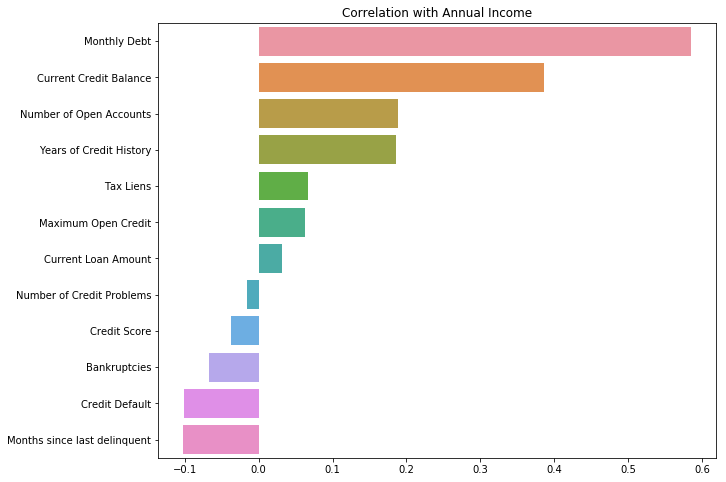

In [23]:
correlations('Annual Income')

#### 3.4 Проверим общие значения 'Annual Income'.

In [24]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

#### 3.5 Посмотрим зависимость 'Annual Income' от 'Monthly Debt' и 'Current Credit Balance'

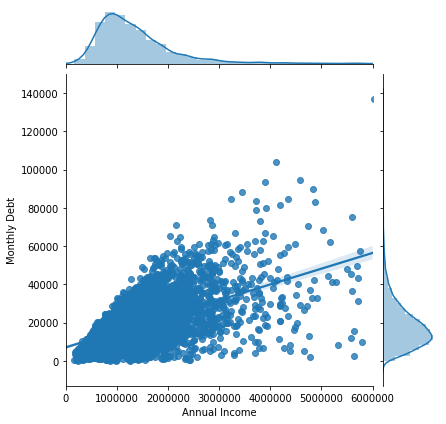

In [25]:
sns.jointplot(df.loc[df['Annual Income'].notnull(), 'Annual Income'], 
            df.loc[df['Annual Income'].notnull(), 'Monthly Debt'], kind='reg', xlim=(0, 6000000));

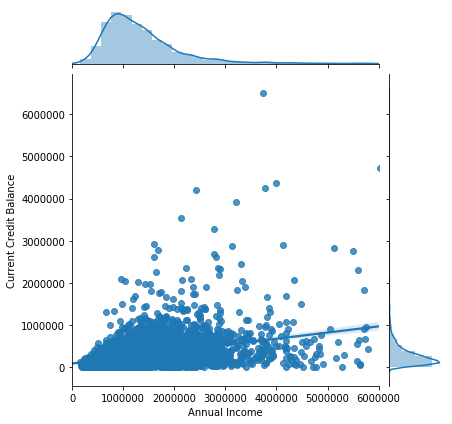

In [26]:
sns.jointplot(df.loc[df['Annual Income'].notnull(), 'Annual Income'], 
            df.loc[df['Annual Income'].notnull(), 'Current Credit Balance'], kind='reg', xlim=(0, 6000000));

#### 3.6 Используем усредненный коэффициент отношения 'Annual Income' к 'Monthly Debt' для того, чтобы восстановить значения в столбце 'Annual Income'. Ограничимся значениями 'Annual Income' до 3000000 для вычисления коэффициента. Будем иметь в виду, что нулевые знчения в знаменателе необходимо отбросить.


In [27]:
def coef(Source, Target, limit):
    # Null Temporary Dataframe
    df_ = pd.DataFrame(columns=['coefs'])
    df_ = df_.fillna(0) # with 0s rather than NaNs
    df_['coefs'] = df.loc[df[Source] < limit, Source]/\
                df.loc[df[Source] < limit, Target]
    df_ = df_.replace(np.Inf, np.NaN)
    
    target_coef = df_.dropna().mean()
    
    return target_coef

In [28]:
ai_md_coef = float(coef('Annual Income', 'Monthly Debt', 3000000))
ai_md_coef

110.15341006169056

#### 3.7 Восстановим значения 'Annual Income' используя все ненулевые значения 'Monthly Debt'.

In [29]:
df.loc[df['Annual Income'].isna(), ['Annual Income']] = df.loc[df['Annual Income'].isna(),\
                                                               ['Monthly Debt']].values * ai_md_coef
df.loc[df['Annual Income'].isna(), ['Annual Income']]

,Annual Income


#### 3.8 Для нулевых значений 'Annual Income' восстановим их из среднего значения, поскольку оба признака 'Monthly Debt' и 'Current Credit Balance' нулевые.

In [30]:
df.loc[df['Annual Income'] == 0]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1643,Rent,0.0,9,0.0,3.0,10.0,0.0,0.0,NaN,0.0,other,Short Term,332156.0,0.0,0.0,NaN,1
3219,Home Mortgage,0.0,10,0.0,3.0,18.5,0.0,0.0,NaN,0.0,debt consolidation,Short Term,79200.0,0.0,0.0,NaN,0
7124,Rent,0.0,1,0.0,4.0,11.0,0.0,0.0,50.0,0.0,debt consolidation,Short Term,134024.0,0.0,0.0,NaN,0


In [31]:
df['Annual Income'].mean()

1504665.9286374685

In [32]:
df.loc[df['Annual Income'] == 0, ['Annual Income']] = df['Annual Income'].mean()

In [33]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


#### 3.9 Продолжим с 'Months since last delinquent'

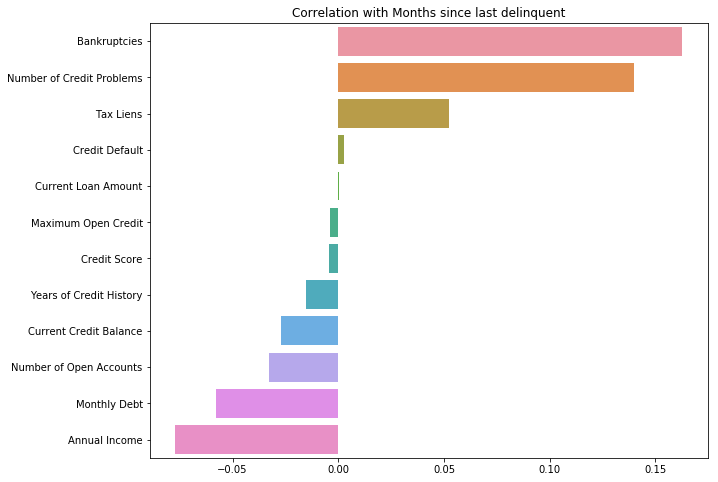

In [34]:
correlations('Months since last delinquent')

In [35]:
df['Bankruptcies'].describe()

count    7486.000000
mean        0.117152
std         0.347192
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: Bankruptcies, dtype: float64

In [36]:
df['Number of Credit Problems'].describe()

count    7500.000000
mean        0.170000
std         0.498598
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         7.000000
Name: Number of Credit Problems, dtype: float64

In [37]:
df['Months since last delinquent'].describe()

count    3419.000000
mean       34.692600
std        21.688806
min         0.000000
25%        16.000000
50%        32.000000
75%        50.000000
max       118.000000
Name: Months since last delinquent, dtype: float64

#### 3.10 Поскольку значения 'Bankruptcies' и  'Number of Credit Problems' в основном нулевые, возьмем усредненное значение.

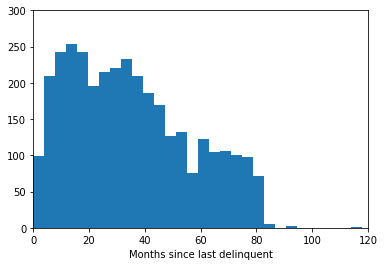

In [38]:
plt.axis([0, 120, 0, 300])
plt.xlabel('Months since last delinquent')
plt.hist(df.loc[df['Months since last delinquent'] < 120, 'Months since last delinquent'], bins=30);

In [39]:
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].mean(skipna = True)

In [40]:
df['Months since last delinquent'].describe()

count    7500.000000
mean       34.692600
std        14.642661
min         0.000000
25%        34.692600
50%        34.692600
75%        34.692600
max       118.000000
Name: Months since last delinquent, dtype: float64

In [41]:
len(df)-df.count()

Home Ownership                     0
Annual Income                      0
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent       0
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

#### 3.11 Продолжим с 'Credit Score'

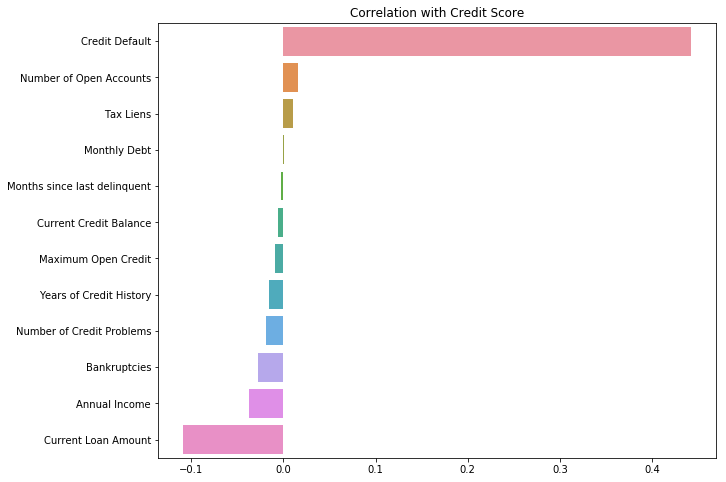

In [42]:
correlations('Credit Score')

#### 3.12 Мы не сможем восстановить значения из 'Credit Default' поскольку оно принимает только одно из двух значений. Возьмем также усредненное значение. 

In [44]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

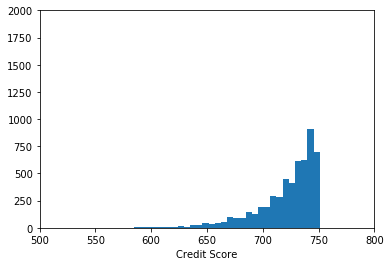

In [55]:
plt.axis([500, 800, 0, 2000])
plt.xlabel('Credit Score')
plt.hist(df.loc[df['Credit Score'] < 800, 'Credit Score'], bins=30);

In [59]:
df.loc[df['Credit Score'] > 760, 'Credit Score'].describe()

count     400.00000
mean     7115.10000
std       306.74537
min      6060.00000
25%      6987.50000
50%      7190.00000
75%      7340.00000
max      7510.00000
Name: Credit Score, dtype: float64

#### Судя по всему, мы столкнулись с аномалией, эти значения 'Credit Score' необходимо разделить на 10. 

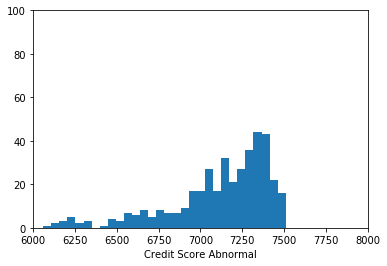

In [64]:
plt.axis([6000, 8000, 0, 100])
plt.xlabel('Credit Score Abnormal')
plt.hist(df.loc[df['Credit Score'] > 760, 'Credit Score'], bins=30);

In [66]:
df.loc[df['Credit Score'] > 760, 'Credit Score'] = df.loc[df['Credit Score'] > 760, 'Credit Score'].values / 10

In [67]:
df['Credit Score'].describe()

count    5943.000000
mean      720.086993
std        27.957233
min       585.000000
25%       708.000000
50%       729.000000
75%       740.000000
max       751.000000
Name: Credit Score, dtype: float64

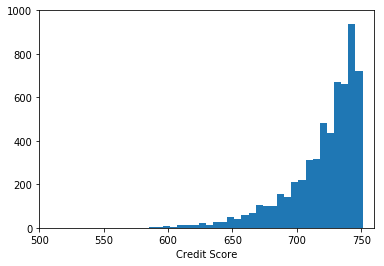

In [72]:
plt.axis([500, 760, 0, 1000])
plt.xlabel('Credit Score')
plt.hist(df['Credit Score'], bins=30);

In [73]:
df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].mean(skipna = True)

In [77]:
len(df)-df.count()

Home Ownership                    0
Annual Income                     0
Years in current job            371
Tax Liens                         0
Number of Open Accounts           0
Years of Credit History           0
Maximum Open Credit               0
Number of Credit Problems         0
Months since last delinquent      0
Bankruptcies                     14
Purpose                           0
Term                              0
Current Loan Amount               0
Current Credit Balance            0
Monthly Debt                      0
Credit Score                      0
Credit Default                    0
dtype: int64

#### 3.13 Рассмотрим 'Years in current job'.

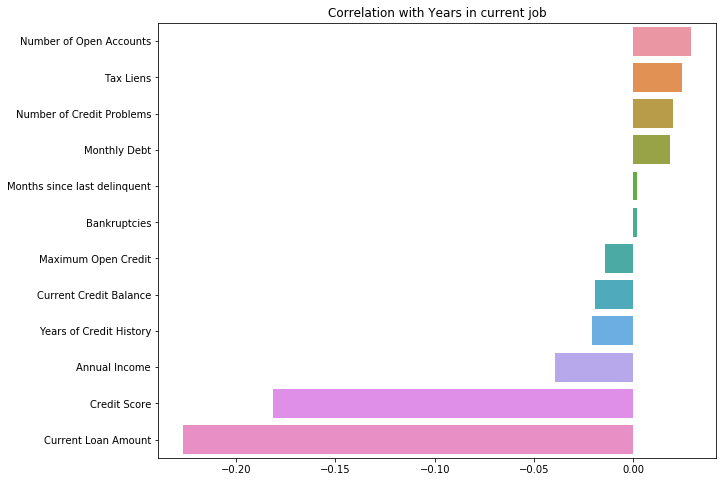

In [80]:
correlations('Years in current job')

#### 3.14 Возьмем нашу функцию но в этотм раз учитывая обратную корреляцию.

In [81]:
def coef_rev(Source, Target, limit):
    # Null Temporary Dataframe
    df_ = pd.DataFrame(columns=['coefs'])
    df_ = df_.fillna(0) # with 0s rather than NaNs
    df_['coefs'] = df.loc[df[Source] < limit, Source]*\
                df.loc[df[Source] < limit, Target]
    df_ = df_.replace(np.Inf, np.NaN)
    
    target_coef = df_.dropna().mean()
    
    return target_coef

In [82]:
df['Years in current job'].describe()

count     7129
unique      11
top         10
freq      2332
Name: Years in current job, dtype: object

In [83]:
yj_cla_coef = coef_rev('Years in current job', 'Current Loan Amount', 11)

TypeError: '<' not supported between instances of 'str' and 'int'

In [88]:
df['Years in current job'].notnull()

0       False
1        True
2        True
3        True
4        True
5        True
6        True
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18       True
19       True
20       True
21       True
22      False
23       True
24      False
25       True
26       True
27       True
28       True
29       True
        ...  
7470     True
7471     True
7472     True
7473     True
7474     True
7475     True
7476     True
7477     True
7478     True
7479     True
7480     True
7481     True
7482     True
7483     True
7484     True
7485     True
7486     True
7487     True
7488     True
7489     True
7490     True
7491     True
7492     True
7493     True
7494     True
7495     True
7496     True
7497     True
7498    False
7499     True
Name: Years in current job, Length: 7500, dtype: bool